# Probabilistic Initiation Set Classifier

## Imports

In [83]:
from sklearn import svm, datasets
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegressionCV as LRCV
from scipy.stats import kde

from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.patches as mpatches
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd

# sns.set(color_codes=True)
# sns.set_style("white")
%matplotlib inline

## Classification

In [57]:
def train_two_class_classifier(X, y):
    return svm.SVC(gamma='scale', probability=True, class_weight='balanced').fit(X, y)

def train_one_class_classifier(tc_svm, X, y, nu):
        # Get subset of inputs that are on the (+) side of the optimistic classifier
        y_pred = tc_svm.predict(X)
        X_pos = X[y_pred == 1]
        y_pos = [1] * X_pos.shape[0]

        # Fit one-class SVM (non-linear) from (+) subset of inputs from two-class SVM
        oc_svm = svm.OneClassSVM(kernel="rbf", nu=nu, gamma="scale")
        
        if len(X_pos) != 0:
            return oc_svm.fit(X_pos, y_pos)
        else:
            # No samples
            return False
        
def one_class_to_two_class_classifier(oc_svm, X):
#     y_pred = (oc_svm.predict(X) > 0).astype(int)
    y_pred = oc_svm.predict(X)
    return train_two_class_classifier(X, y_pred)

In [21]:
# def platt_scale(ocsvm, X, train_size, cv_size):
# def platt_scale(X, y, train_size, cv_size):
#     """
#     Uses Platt Scalling to get probability values from one-class SVM
    
#     Args:
#         clf: OneClassSVM classifier (post-fit on TCSVM (+) data)
#         X_data: data that clf was fitted on
#         y_labels: labels that cls was fitted on 
    
#     Returns:
        
#     """

#     # 2. Split the data and SVM labels
#     X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)


#     # 3. Train using logistic regression layer with cross validation 
#     lr = LRCV(cv=cv_size)
#     lr.fit(X_train, y_train)
    
#     # 4. Return prediction probabilities on test data    
#     return lr

## Data processing

In [59]:
# X, y = datasets.make_classification(n_samples=300, n_features=2,
#                                     n_informative=2, n_redundant=0)
X, y = datasets.make_circles(n_samples=200, noise=0.1, factor=0.4)

# Call classifiers
tc_svm = train_two_class_classifier(X, y)
oc_svm = train_one_class_classifier(tc_svm, X, y, nu=0.8)
approx_oc_svm = one_class_to_two_class_classifier(oc_svm, X)

## Decision making

In [79]:
def is_init_true(clf, ground_state):
    return random.random() < clf.predict_proba(ground_state.reshape(1,-1)).flatten()[-1]

def is_term_true(clf, ground_state):
    return clf.predict(ground_state.reshape(1,-1))[-1] == 1

In [80]:
state = X[0]
# print("init: {}".format(is_init_true(tc_svm, state)))
# print("term: {}".format(is_term_true(oc_svm, state)))


init: False
term: False


False

In [89]:
def local_seed():
    seed = random.Random(0)
    return seed.random()

In [95]:

print(random.random())
print(local_seed())

0.6697532509732289
0.8444218515250481


## Plotting

In [22]:
def make_meshgrid(x, y, h=.01):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def create_plots(models, titles, X, y, grid):
    """Creates plots of models.
    
        Parameters
        ----------
        models : tuple of models
        titles : tuple of title names
        X : input
        y: class labels
        grid : tuple of grid size 
    """
    
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    for clf, title in zip(models, titles):

        fig, ax = plt.subplots(1,1)
        plot_contours(ax, clf, xx, yy,
                      cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
#         ax.set_xlabel('x')
#         ax.set_ylabel('y')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)
        plt.show()

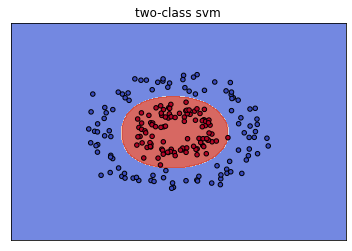

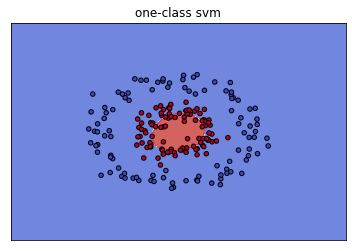

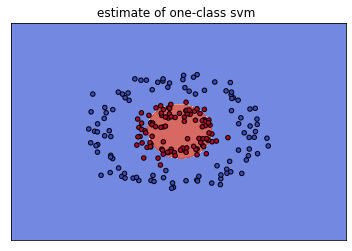

In [25]:
# Plot classifiers
models = [tc_svm, oc_svm, approx_oc_svm]

titles = ['two-class svm', 'one-class svm', 'estimate of one-class svm ']
create_plots(models, titles, X, y, grid=(1,len(models)))

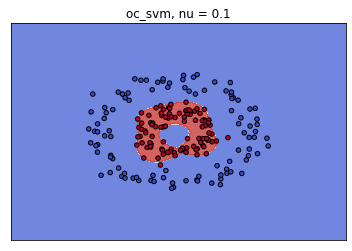

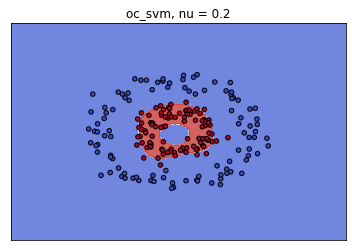

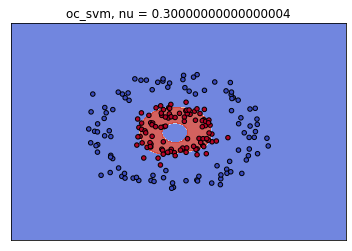

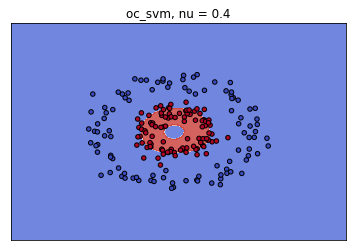

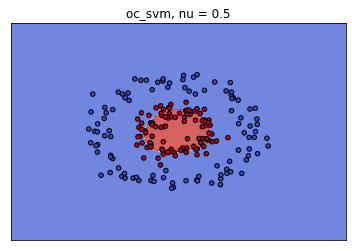

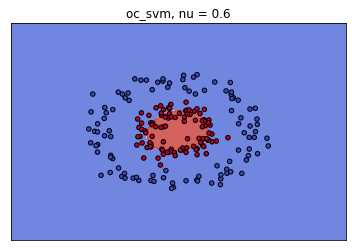

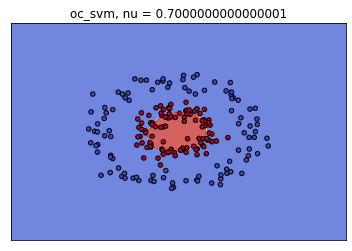

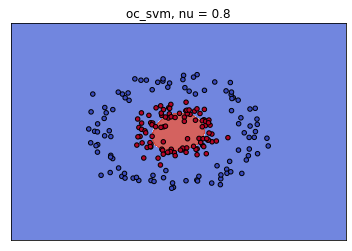

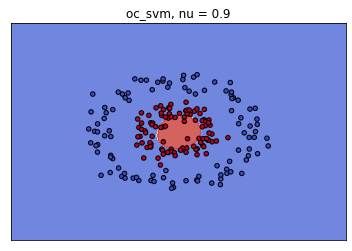

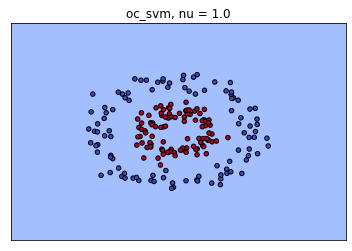

In [26]:
# Plot different nu values
tc_svm = train_two_class_classifier(X, y)

models, titles = [], []
for nu in np.linspace(0.1,1,10):
    models.append(train_one_class_classifier(tc_svm, X, y, nu=nu))
    titles.append('oc_svm, nu = {}'.format(nu))

create_plots(models, titles, X, y, grid=(1,len(models)))

In [8]:
def plot_state_probs(X, clfs, option_id, cmaps, cnt):    
    
    # Generate mesh grid
    x_coord, y_coord = X[:,0], X[:,1]
    x_mesh, y_mesh = make_meshgrid(x_coord, y_coord)
    
    for (clf_name, clf), cmap in zip(clfs.items(), cmaps):
        
        fig, ax = plt.subplots()
        
        # Only plot positive predictions
        X_mesh = np.vstack([x_mesh.flatten(), y_mesh.flatten()]).T
        probs = clf.predict_proba(X_mesh)[:,1]
        preds = (clf.predict(X_mesh) > 0).astype(int)
        probs = np.multiply(probs, preds)
        
        ax.set_title('Option {} - Probability estimates of {} (t = {})'.format(option_id, clf_name, cnt))

        states = ax.pcolormesh(x_mesh, y_mesh, probs.reshape(x_mesh.shape), shading='gouraud', cmap=cmap, vmin=0, vmax=1)
        cbar = fig.colorbar(states)
    
        ax.set_xticks(())
        ax.set_yticks(())
        plt.show()

In [9]:
# for i in np.linspace(0,3,31,endpoint=False):
#     print('start={}'.format(i))
# sns.palplot(sns.cubehelix_palette(n_colors=2, start=2.8, rot=0.1, light=1, dark=0.3, reverse=True))
# sns.palplot(sns.cubehelix_palette(n_colors=2, start=2, rot=0.1, light=1, dark=0.3))

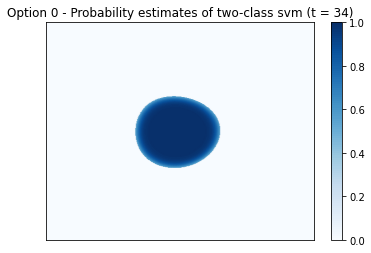

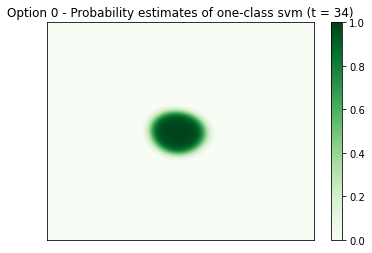

In [10]:
# Plot classifiers
num_colors = 100
cmaps = [cm.get_cmap('Blues', num_colors), cm.get_cmap('Greens', num_colors)]

clfs = {'two-class svm': tc_svm, 'one-class svm':oc_svm}
plot_state_probs(X, clfs, 0, cmaps, 34)

In [11]:
all_tc_svm_probs = {}
all_tc_svm_probs[0] = ([0.9, 0.8, 0.7], [1,2,3])
all_tc_svm_probs[1] = ([0.85, 0.75, 0.65], [2,3,4])
all_tc_svm_probs[2] = ([0.725, 0.625, 0.525], [3,4,5])

all_oc_svm_probs = {}
all_oc_svm_probs[0] = ([0.1, 0.2, 0.3], [1,2,3])
all_oc_svm_probs[1] = ([0.25, 0.35, 0.45], [2,3,4])
all_oc_svm_probs[2] = ([0.325, 0.425, 0.5], [3,4,5])

all_clf_probs = {'tc_svm':all_tc_svm_probs, 'oc_svm':all_oc_svm_probs}

In [12]:
def plot_prob(all_clf_probs):
    for clf_name, clf_probs in all_clf_probs.items():
        colors = sns.hls_palette(len(clf_probs), l=0.5)
        for i, (opt_id, opt_probs) in enumerate(clf_probs.items()):
            probs, episodes = opt_probs
            if 'tc' in clf_name:
                plt.plot(episodes, probs, color=colors[i], label="{} - {}".format(opt_id, clf_name))
            else:
                plt.plot(episodes, probs, color=colors[i], label="{} - {}".format(opt_id, clf_name), linestyle='--')

    plt.title("Average Probability Estimates")
    plt.ylabel("Probabilities")
    plt.xlabel("Episodes")
    plt.legend(title="Options", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        
    plt.show()

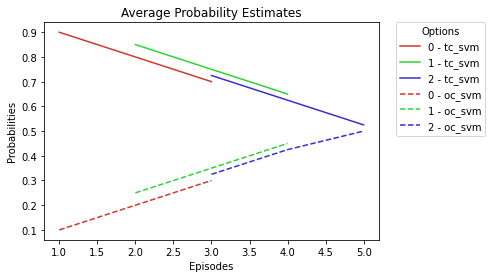

In [13]:
# Test call
plot_prob(all_clf_probs)

In [151]:
def plot_learning_curves(tests):
    colors = sns.hls_palette(len(tests), l=0.5)
    for i, (label, rewards) in tests.items():
        plt.plot(rewards, color=colors[i], label=label)
        
    plt.title("Domain")
    plt.ylabel("Rewards")
    plt.xlabel("Episodes")
    plt.legend(title="Tests", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

In [154]:
tests = {}
tests[0] = ("0 - num_subgoal_hits=10, nu=0.8", [-2000, -1800, -1500, -1000, -500])
tests[1] = ("1 - num_subgoal_hits=10, nu=0.8", [-2000, -1400, -1000, -600, -200])
tests[2] = ("3 - num_subgoal_hits=10, nu=0.8", [-2000, -1000, -100, -60, -20])

# Test call
plot_learning_curves(tests)

TypeError: unhashable type: 'list'

In [15]:
def plot_boundary(X_global, X_buff, y_labels, clfs, colors, option_id, cnt):
    x_coord, y_coord = X_global[:,0], X_global[:,1]
    x_mesh, y_mesh = make_meshgrid(x_coord, y_coord, h=0.008)
    
    # Plot classifier boundaries
    alpha, patches = 0.7, []
    for (clf_name, clf), color in zip(clfs.items(), colors):        
        z = clf.predict(np.c_[x_mesh.ravel(), y_mesh.ravel()])
        z = (z > 0).astype(int)
        z = z.reshape(x_mesh.shape)
        z = np.ma.masked_where(z == 0, z)

        cf = plt.contourf(x_mesh, y_mesh, z, colors=color, alpha=alpha)
        patches.append(mpatches.Patch(color=color, label=clf_name, alpha=alpha))
    
    # Plot positive examples
    X_pos = X_buff[y_labels == 1]
    x_pos_coord, y_pos_coord = X_pos[:,0], X_pos[:,1]
    
#     pos_color = '#34495e'
    pos_color = 'black'
    p = plt.scatter(x_pos_coord, y_pos_coord, marker='+', c=pos_color, label='positive samples')
    
    patches.append(p)
    
    plt.xticks(())
    plt.yticks(())
    plt.title("Option {} - Classifier boundaries (t = {})".format(option_id, cnt))
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

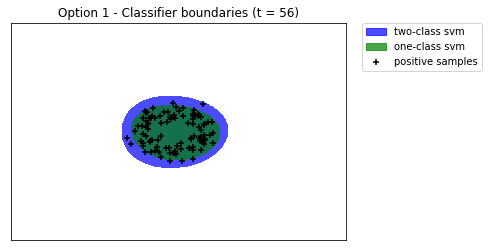

In [16]:
# Test call
clfs = {'two-class svm':tc_svm, 'one-class svm':oc_svm}
colors = ['blue', 'green']
plot_boundary(X, X, y, clfs, colors, 1, 56)